라이브러리

In [64]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense, concatenate, Input
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Model
from keras.models import Sequential
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean, cosine, correlation
from sklearn.metrics import mean_squared_error, mean_absolute_error, pairwise_distances
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
tank = 4
model_name = ['tank'+str(tank)+'_lstm_all', 'tank'+str(tank)+'_lstm_only-feed_no180', 'tank'+str(tank)+'_lstm_crop720_only-feed']

In [65]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

데이터셋 설정

In [66]:
#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_validation_food_supply_tb.csv")
japonica_validation_sensor_val = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_validation_sensor_val_tb.csv")
japonica_validation_sensor_val1 = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_validation_sensor_val_tb1.csv")

# 자포니카 사료 공급 데이터 정제
# null제거
japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]

# 시계열 데이터 변환
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

# 자포니카 센서 데이터 정제

# 한 개 탱크
japonica_validation_sensor_val_tb = japonica_validation_sensor_val[japonica_validation_sensor_val['tank_id']==tank]
japonica_validation_sensor_val_tb1 = japonica_validation_sensor_val1[japonica_validation_sensor_val1['tank_id']==tank]

#시계열 변환
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

japonica_validation_sensor_val_tb1["mea_dt"] = japonica_validation_sensor_val_tb1["mea_dt"].apply(str)
japonica_validation_sensor_val_tb1["mea_dt"] = japonica_validation_sensor_val_tb1["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb1['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb1['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 시계열 데이터의 개수 확인
validation_counts = japonica_validation_sensor_val_tb.groupby(japonica_validation_sensor_val_tb['mea_dt'].dt.date).size()
validation_counts = japonica_validation_sensor_val_tb1.groupby(japonica_validation_sensor_val_tb1['mea_dt'].dt.date).size()

# 개수가 1440이 아닌 시계열 삭제
to_delete = validation_counts[validation_counts != 1440].index
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[~japonica_validation_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]
japonica_validation_sensor_val_tb1 = japonica_validation_sensor_val_tb1[~japonica_validation_sensor_val_tb1['mea_dt'].dt.date.isin(to_delete)]

#시계열 데이터 문자 타입으로 변경
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)

japonica_validation_sensor_val_tb1["mea_dt"] = japonica_validation_sensor_val_tb1["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_validation_sensor_val_tb1["mea_dt"] = japonica_validation_sensor_val_tb1["mea_dt"].str.slice(start=0, stop=16)


# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation1 = pd.merge(left = japonica_validation_sensor_val_tb1, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation1['mea_dt'] = pd.to_datetime(japonica_validation1['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_validation_features = japonica_validation[feature_origin]
japonica_validation_features1 = japonica_validation1[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_validation_features = japonica_validation_features.fillna(0)
japonica_validation_features1 = japonica_validation_features1.fillna(0)

# 날짜 데이터를 인덱스로 전환
japonica_validation_features.set_index('mea_dt', inplace=True)
japonica_validation_features1.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_validation_data = japonica_validation_features.sort_index()
japonica_validation_data1 = japonica_validation_features1.sort_index()

# 8월 1달간 데이터만 추출
japonica_validation_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-10 23:59']
japonica_validation_data1 = japonica_validation_data1.loc['2021-07-21 00:00':'2021-09-10 23:59']

#문제 날짜 삭제
date_to_remove = pd.to_datetime('2021-08-03')
japonica_validation_data = japonica_validation_data.drop(japonica_validation_data[japonica_validation_data.index.date == date_to_remove.date()].index)
japonica_validation_data1 = japonica_validation_data1.drop(japonica_validation_data1[japonica_validation_data1.index.date == date_to_remove.date()].index)

japonica_validation_features_X_a = japonica_validation_data[['do_mg', 'do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_validation_features_X_b = japonica_validation_data[['feed_quantity']]
japonica_validation_features_y = japonica_validation_data[['do_mg']]

japonica_validation_features_X_a1 = japonica_validation_data1[['do_mg', 'do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_validation_features_X_b1 = japonica_validation_data1[['feed_quantity']]
japonica_validation_features_y1 = japonica_validation_data1[['do_mg']]

C:\Users\rladn\AppData\Local\Temp\ipykernel_1788\470188951.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
C:\Users\rladn\AppData\Local\Temp\ipykernel_1788\470188951.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
C:\Users\rladn\AppData\Local\Temp\ipykernel_1788\470188951.py:24: Set

In [67]:
japonica_validation_data.describe()

,tank_id,do_mg,do_temp,ph,orp,co2_mg,air_oxy,light_ma,feed_quantity,water_quantity
count,67640.0,67640.000000,67640.000000,67640.000000,67640.000000,67640.000000,67640.000000,67640.000000,67640.000000,67640.000000
mean,4.0,8.701360,29.281736,5.238524,227.075132,28.285225,0.064410,4.098099,0.015228,0.019796
std,0.0,2.070549,1.480557,0.512874,21.856526,8.116524,0.751185,0.214035,0.463903,0.603074
min,4.0,1.500000,20.100000,3.970000,108.500000,0.000000,0.000000,3.800000,0.000000,0.000000
25%,4.0,7.700000,28.900000,4.830000,214.300000,21.200000,0.000000,4.000000,0.000000,0.000000
50%,4.0,8.700000,29.100000,5.250000,225.550000,31.000000,0.000000,4.000000,0.000000,0.000000
75%,4.0,9.700000,30.500000,5.460000,238.500000,34.000000,0.000000,4.100000,0.000000,0.000000
max,4.0,20.000000,31.700000,7.750000,369.000000,50.000000,12.700000,5.700000,16.000000,20.800000


모델 평가

In [68]:
def grapeNEva5(y_test, y_test1, X_test_shape, feed):
    model = []
    array_index = 0
    
    for i in range(len(model_name)):
        model.append(load_model(model_name[i]+'.h5', custom_objects={'r_squared': r_squared}))
    
    X_pred1 = model[0].predict(X_test_shape)
    X_pred1 = np.asarray(X_pred1, dtype=np.float64)
    X_pred1 = X_pred1.reshape((-1))
    
    X_pred2_result_array = np.asarray(feed)
    X_pred2_result_array = X_pred2_result_array.reshape((-1, 1, 1))
    X_pred2_result = model[1].predict(X_pred2_result_array)
    X_pred2_result = np.asarray(X_pred2_result, dtype=np.float64)
    X_pred2_result = X_pred2_result.reshape((-1))

    X_pred3_result = np.ones(len(feed))
    X_pred4_result = np.ones(len(feed))

    #X_pred2_result_nomal = np.ones(len(feed))
    X_pred3_result_nomal = np.ones(len(feed))
    #X_pred4_result_nomal = np.ones(len(feed))
    nomal = 0
    for i in range(len(feed)):
        if feed[i] > 0 :
            nomal_array = np.asarray(0)
            nomal_array = nomal_array.reshape((-1, 1, 1))
            nomal = model[1].predict(nomal_array)
            nomal = np.asarray(nomal, dtype=np.float64)
            nomal = nomal.reshape((-1))

            array_index = i
            X_pred2_array = np.asarray(feed[i])
            X_pred2_array = X_pred2_array.reshape((-1, 1, 1))
            X_pred2 = model[1].predict(X_pred2_array)
            X_pred2 = np.asarray(X_pred2, dtype=np.float64)
            X_pred2 = X_pred2.reshape((-1))[0]

            #print(i)

            array_length = 720
            #X_pred2_ones = np.ones(array_length)
            #X_pred2_ones = np.asarray(X_pred2_ones, dtype=np.float64)
            #X_pred2_ones = X_pred2_ones * X_pred2
            
            X_pred3_array = np.zeros(array_length)
            X_pred3_array[270] = feed[i]
            X_pred3_array = X_pred3_array.reshape((-1, array_length, 1))
            X_pred3 = model[2].predict(X_pred3_array)
            X_pred3 = np.asarray(X_pred3, dtype=np.float64)
            X_pred3 = X_pred3.reshape((-1))

            X_pred4 = X_pred3 * X_pred2 / nomal

            #X_pred2_nomal = X_pred2_ones / nomal
            X_pred3_nomal = X_pred3 / nomal
            #X_pred4_nomal = X_pred4 / nomal


            x = 0
            if array_index < 270 :
                x = 270 - array_index
                #X_pred2_ones = X_pred2_ones[x:]
                X_pred3 = X_pred3[x:]
                X_pred4 = X_pred4[x:]
                #X_pred2_nomal = X_pred2_nomal[x:]
                X_pred3_nomal = X_pred3_nomal[x:]
                #X_pred4_nomal = X_pred4_nomal[x:]


            #X_pred2_result[array_index+x-270:array_index-270+x+len(X_pred2_ones)] = X_pred2_result[array_index+x-270:array_index-270+x+len(X_pred2_ones)] * X_pred2_ones
            X_pred3_result[array_index+x-270:array_index-270+x+len(X_pred3)] = X_pred3_result[array_index+x-270:array_index-270+x+len(X_pred3)] * X_pred3
            X_pred4_result[array_index+x-270:array_index-270+x+len(X_pred4)] = X_pred4_result[array_index+x-270:array_index-270+x+len(X_pred4)] * X_pred4
            #X_pred2_result_nomal[array_index+x-270:array_index-270+x+len(X_pred2_nomal)] = X_pred2_result_nomal[array_index+x-270:array_index-270+x+len(X_pred2_nomal)] * X_pred2_nomal
            X_pred3_result_nomal[array_index+x-270:array_index-270+x+len(X_pred3_nomal)] = X_pred3_result_nomal[array_index+x-270:array_index-270+x+len(X_pred3_nomal)] * X_pred3_nomal
            #X_pred4_result_nomal[array_index+x-270:array_index-270+x+len(X_pred4_nomal)] = X_pred2_result_nomal[array_index+x-270:array_index-270+x+len(X_pred4_nomal)] * X_pred4_nomal


    date_format = DateFormatter("%m-%d %H")  # 월-일 형식으로 설정

    # # 그래프 생성
    # plt.figure(figsize=(15, 7))
    # plt.plot(y_test.index, y_test, label='Sensor DO')  # x축에 년월일, y축에 시분
    # plt.xticks(fontsize=15)  # x 축의 눈금 글자 크기 조절
    # plt.yticks(fontsize=15)
    # plt.xlabel('DATE', fontsize=20)
    # plt.ylabel('DO', fontsize=20)
    # plt.gca().xaxis.set_major_formatter(date_format)
    # plt.title('Tank' + str(tank) + ' Sensor DO', fontsize=25)
    # plt.legend(['Sensor DO'], fontsize=15)
    # plt.show()
    

    # # 그래프 생성
    # plt.figure(figsize=(15, 7))
    # plt.plot(y_test.index, X_pred3_result, color='red', label='Weight Model First')  # x축에 년월일, y축에 시분
    # plt.plot(y_test.index, X_pred2_result, color='orange', label='Weight Model Second')  # x축에 년월일, y축에 시분
    # plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    # plt.xticks(fontsize=15)  # x 축의 눈금 글자 크기 조절
    # plt.yticks(fontsize=15)
    # plt.gca().xaxis.set_major_formatter(date_format)
    # plt.xlabel('DATE', fontsize=20)
    # plt.ylabel('DO', fontsize=20)
    # plt.title('Tank' + str(tank) + ' Weight Model First & Second', fontsize=25)
    # plt.legend(['Weight Model First','Weight Model Second','Feed Quantity'], fontsize=15)
    # plt.show()

    # # 그래프 생성
    # plt.figure(figsize=(15, 7))
    # plt.plot(y_test.index, X_pred3_result_nomal, color='red', label='Weight Model')  # x축에 년월일, y축에 시분
    # plt.xlabel('DATE', fontsize=20)
    # plt.ylabel('DO', fontsize=20)
    # plt.xticks(fontsize=15)  # x 축의 눈금 글자 크기 조절
    # plt.yticks(fontsize=15)
    # plt.gca().xaxis.set_major_formatter(date_format)
    # plt.title('Tank' + str(tank) + ' Weight Model', fontsize=25)
    # plt.legend(['Weight Model'], fontsize=15)
    # plt.show()

    final_predictions = X_pred1 * X_pred3_result_nomal

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test1, color='darkgray', label='Sensor DO', linewidth=0.75)  # x축에 년월일, y축에 값
    #plt.plot(y_test.index, y_test, color='green', label='Sensor DO')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred1, color='dodgerblue', label='Regression Model', linewidth=2)  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, final_predictions, color='red', label='Mixted Model', linewidth=2)  # x축에 년월일, y축에 시분
    for i in range(len(y_test.index)):
        if feed[i] > 0:
            plt.scatter(y_test.index[i], feed[i],color='green', marker='o', label=f'Data Point {i+1}')
    #plt.plot(y_test.index, feed, color='goldenrod', marker='o', linestyle='None', label='Feed Quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('DATE', fontsize=20)
    plt.ylabel('DO', fontsize=20)
    plt.xticks(fontsize=15)  # x 축의 눈금 글자 크기 조절
    plt.yticks(fontsize=15)
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.title('Results of the prediction for tank #' + str(tank), fontsize=25)
    #plt.title('Results of the prediction for tank #2', fontsize=25)
    plt.legend(['Sensor DO','Regression Model','Mixed Model','Feed Quantity'], fontsize=15)
    plt.show()

########################################
    # y_test1 = y_test.values
    # y_test1 = y_test1 / final_predictions
    
    # # 그래프 생성
    # plt.figure(figsize=(15, 7))
    # plt.plot(y_test.index, y_test1, color='darkgray', label='Sensor DO')  # x축에 년월일, y축에 값
    # #plt.plot(y_test.index, y_test, color='green', label='Sensor DO')  # x축에 년월일, y축에 값
    # plt.plot(y_test.index, X_pred1, color='dodgerblue', label='Regression Model', linewidth=2)  # x축에 년월일, y축에 시분
    # plt.plot(y_test.index, final_predictions, color='red', label='Mixture Model', linewidth=2)  # x축에 년월일, y축에 시분
    # for i in range(len(y_test.index)):
    #     if feed[i] > 0:
    #         plt.scatter(y_test.index[i], feed[i],color='green', marker='o', label=f'Data Point {i+1}')
    # #plt.plot(y_test.index, feed, color='goldenrod', marker='o', linestyle='None', label='Feed Quantity')  # x축에 년월일, y축에 시분
    # plt.xlabel('DATE', fontsize=20)
    # plt.ylabel('DO', fontsize=20)
    # plt.xticks(fontsize=15)  # x 축의 눈금 글자 크기 조절
    # plt.yticks(fontsize=15)
    # plt.gca().xaxis.set_major_formatter(date_format)
    # #plt.title('Rresults of the prediction for the tank #' + str(tank), fontsize=25)
    # plt.title('Rresults of the prediction for the tank #2', fontsize=25)
    # plt.legend(['Sensor DO','Regression Model','Mixture Model','Feed Quantity'], fontsize=15)
    # plt.show()

    y_test_reshape = np.asarray(y_test1, dtype=np.float64)
    y_test_reshape = y_test_reshape.reshape((-1,1))

    # 유클리디안 거리 계산
    euclidean_distance1 = euclidean(y_test_reshape.flatten(), X_pred1.flatten())
    euclidean_distance2 = euclidean(y_test_reshape.flatten(), final_predictions.flatten())
    print("Euclidean Distance\n", f"{euclidean_distance1:.3f}" ," → ", f"{euclidean_distance2:.3f}")

    # 코사인 유사도 계산
    cosine_similarity1 = 1 - cosine(y_test_reshape.flatten(), X_pred1.flatten())
    cosine_similarity2 = 1 - cosine(y_test_reshape.flatten(), final_predictions.flatten())
    print("Cosine Similarity\n", f"{cosine_similarity1:.3f}" ," → ", f"{cosine_similarity2:.3f}")

    # 상관관계 계산
    correlation_coefficient1 = correlation(y_test_reshape.flatten(), X_pred1.flatten())
    correlation_coefficient2 = correlation(y_test_reshape.flatten(), final_predictions.flatten())
    print("Correlation Coefficient\n", f"{correlation_coefficient1:.3f}" ," → ", f"{correlation_coefficient2:.3f}")

    mse1 = mean_squared_error(y_test_reshape.flatten(), X_pred1.flatten())
    mse2 = mean_squared_error(y_test_reshape.flatten(), final_predictions.flatten())
    print("Mean Squared Error\n", f"{mse1:.3f}" ," → ", f"{mse2:.3f}")

    # 평균 절대 오차 계산
    mae1 = mean_absolute_error(y_test_reshape.flatten(), X_pred1.flatten())
    mae2 = mean_absolute_error(y_test_reshape.flatten(), final_predictions.flatten())
    print("Mean Absolute Error\n", f"{mae1:.3f}" ," → ", f"{mae2:.3f}")

    # 상관관계 계산
    correlation_coefficient1 = np.corrcoef(y_test_reshape.flatten(), X_pred1.flatten())[0, 1]
    correlation_coefficient2 = np.corrcoef(y_test_reshape.flatten(), final_predictions.flatten())[0, 1]
    print("Correlation Coefficient\n", f"{correlation_coefficient1:.3f}" ," → ", f"{correlation_coefficient2:.3f}")


    date_format = DateFormatter("%H")  # 월-일 형식으로 설정

    # 그래프 생성
    # plt.figure(figsize=(15, 7))
    # plt.plot(y_test.index, X_pred3_result_nomal, color='red', label='Pattern')  # x축에 년월일, y축에 시분
    # plt.xlabel('DATE', fontsize=20)
    # plt.ylabel('DO', fontsize=20)
    # plt.gca().axes.get_yaxis().set_visible(False)
    # plt.xticks(fontsize=15)  # x 축의 눈금 글자 크기 조절
    # plt.yticks(fontsize=15)
    # plt.gca().xaxis.set_major_formatter(date_format)
    # plt.title('DO Pattern', fontsize=25)
    # plt.legend(['Pattern'], fontsize=15)
    # plt.show()

In [69]:
# y_date = japonica_validation_features_y.loc['2021-07-22 03:00':'2021-09-08 23:59']

# y_test = y_date[['do_mg']]

# nCar = y_test.shape[0] # 데이터 개수
# nVar = y_test.shape[1] # 변수 개수
# print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# X_test1 = japonica_validation_features_X_a.loc['2021-07-22 00:00':'2021-09-08 20:59']
# X_test2 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-09-08 23:59']

# X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
# X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 9))

# # shape확인
# nCar = X_test_reshape1.shape[0] # 데이터 개수
# nVar = X_test_reshape1.shape[2] # 변수 개수
# print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# # shape확인
# nCar = X_test_reshape1.shape[0] # 데이터 개수
# nVar = X_test_reshape1.shape[2] # 변수 개수
# print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# feed = X_test2[['feed_quantity']]
# feed = np.asarray(feed, dtype=np.float64)
# feed = feed.reshape(-1)

# grapeNEva5(y_test, X_test_reshape1, feed)

C:\Users\rladn\AppData\Local\Temp\ipykernel_1788\1085597047.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_features_X_b.at['2021-08-21 08:00', 'feed_quantity'] = 6


nCar: 1260 nVar: 1
nCar: 7 nVar: 9
nCar: 7 nVar: 9
1/1 [==============================] - 0s 99ms/step


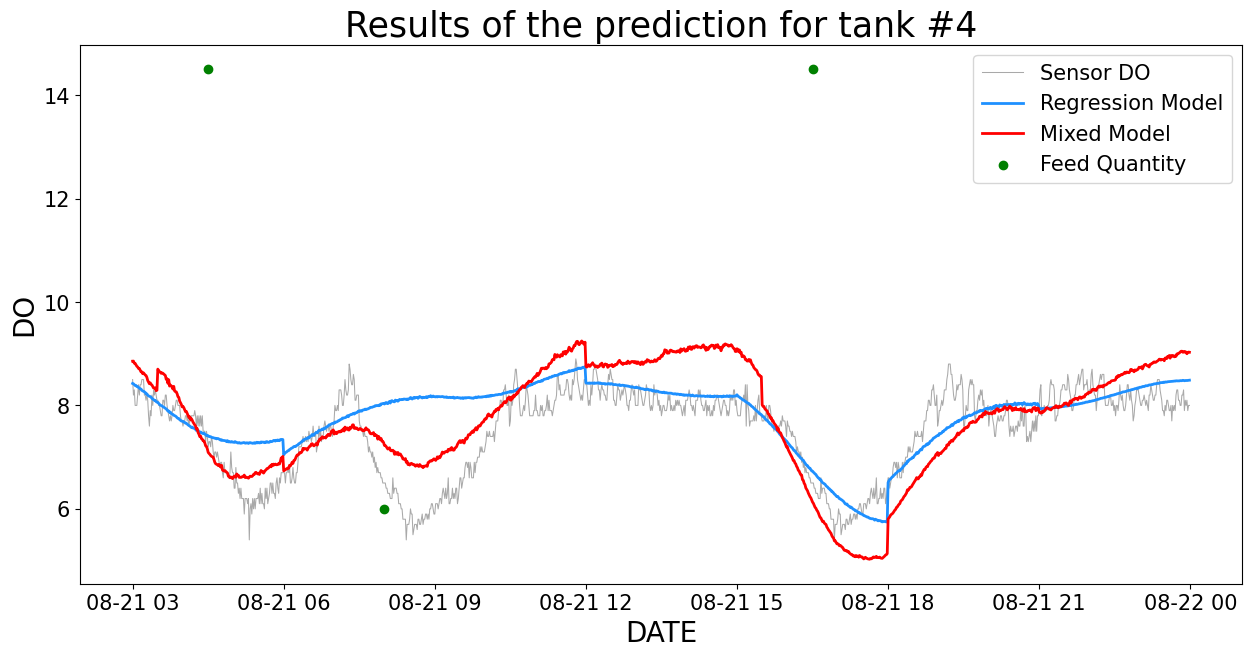

Euclidean Distance
 26.081  →  24.215
Cosine Similarity
 0.996  →  0.997
Correlation Coefficient
 0.389  →  0.204
Mean Squared Error
 0.540  →  0.465
Mean Absolute Error
 0.493  →  0.581
Correlation Coefficient
 0.611  →  0.796


In [70]:
japonica_validation_features_X_a.at['2021-08-21 08:00', 'feed_quantity'] = 6
japonica_validation_features_X_b.at['2021-08-21 08:00', 'feed_quantity'] = 6

y_date = japonica_validation_features_y.loc['2021-08-21 03:00':'2021-08-21 23:59']

y_test = y_date[['do_mg']]

y_date1 = japonica_validation_features_y1.loc['2021-08-21 03:00':'2021-08-21 23:59']

y_test1 = y_date1[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-08-21 00:00':'2021-08-21 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-08-21 03:00':'2021-08-21 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 9))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva5(y_date, y_test1, X_test_reshape1, feed)

nCar: 7020 nVar: 1
nCar: 39 nVar: 9
nCar: 39 nVar: 9


C:\Users\rladn\AppData\Local\Temp\ipykernel_1788\3812362547.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_features_X_b.at['2021-08-21 08:00', 'feed_quantity'] = 12
C:\Users\rladn\AppData\Local\Temp\ipykernel_1788\3812362547.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_features_X_b.at['2021-08-23 20:00', 'feed_quantity'] = 12


1/1 [==============================] - 0s 95ms/step


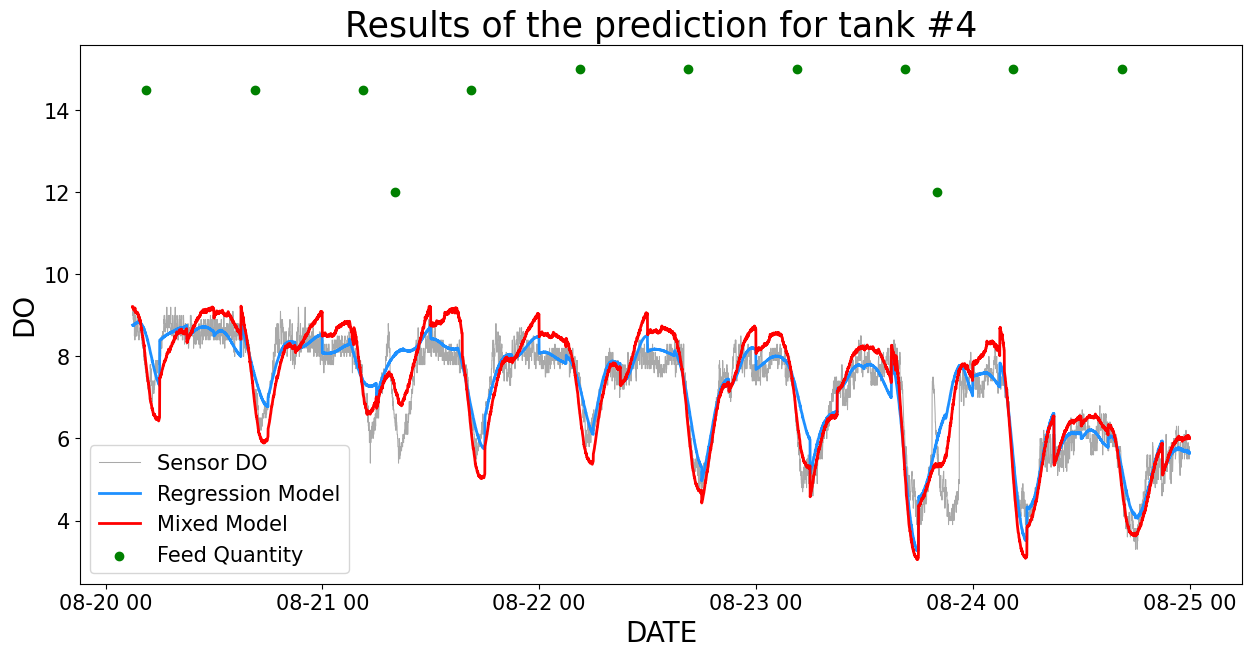

Euclidean Distance
 50.309  →  52.456
Cosine Similarity
 0.997  →  0.997
Correlation Coefficient
 0.105  →  0.090
Mean Squared Error
 0.361  →  0.392
Mean Absolute Error
 0.383  →  0.486
Correlation Coefficient
 0.895  →  0.910


In [71]:
japonica_validation_features_X_a.at['2021-08-21 08:00', 'feed_quantity'] = 12
japonica_validation_features_X_b.at['2021-08-21 08:00', 'feed_quantity'] = 12

japonica_validation_features_X_a.at['2021-08-23 20:00', 'feed_quantity'] = 12
japonica_validation_features_X_b.at['2021-08-23 20:00', 'feed_quantity'] = 12

y_date = japonica_validation_features_y.loc['2021-08-20 03:00':'2021-08-24 23:59']

y_test = y_date[['do_mg']]

y_date1 = japonica_validation_features_y1.loc['2021-08-20 03:00':'2021-08-24 23:59']

y_test1 = y_date1[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-08-20 00:00':'2021-08-24 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-08-20 03:00':'2021-08-24 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 9))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva5(y_test, y_test1, X_test_reshape1, feed)